<a href="https://colab.research.google.com/github/JD-man/GAN_Study/blob/main/3.FirstGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 첫번째 GAN 구현하기

컴퓨터 입장에서 보면 이미지는 값을 담은 행렬에 불과하다.  
흑백이미지는 2차원, 컬러 이미지는 3차원 행렬이다.  
화면에 그려질 때 이 행렬에 있는 픽셀 값이 이미지의 선, 모서리, 곡선 등 모든 시각적 요소를 표현한다.  
이 값들은 데이터셋에 있는 각 이미지에 복잡하게 걸쳐 있는 어떤 분포를 따른다.  
어떤 분포를 따르지 않는다면 이미지는 랜덤한 잡음과 다를 바가 없다.  
객체 인식 모델은 이미지에 있는 패턴을 학습한다.  
이런 작업의 역과정으로 생성자를 생각할 수 있다.


# 비용함수 (손실함수)

- J<sup>(G) : 생성자의 비용함수  
- J<sup>(D) : 판별자의 비용함수
- $\theta$<sup>(G) : 생성자의 파라미터 
- $\theta$<sup>(D) : 판별자의 파라미터  

---  

전통적인 신경망의 비용함수 : J($\theta$)  
GAN의 두 네트워크는 비용 함수가 두 네트워크의 파라미터에 모두 의존한다  
생성자의 비용 함수 : J<sup>(G)</sup>($\theta$<sup>(G)</sup>, $\theta$<sup>(D)</sup>)  
판별자의 비용 함수 : J<sup>(D)</sup>($\theta$<sup>(G)</sup>, $\theta$<sup>(D)</sup>)  

---  
훈련하는 동안 생성자는 자신의 파라미터만 튜닝시킬 수 있고  
판별자도 자신의 파라미터만 튜닝할 수 있다.  
즉, 각 네트워크는 손실을 정의하는 것 중에(정의역) 중 일부만 제어한다



# 오차행렬의 측면

- 판별자는 진짜 양성과 진짜 음성 분류를 최대화하려고 노력한다.  
- 반대로 생성자의 목적은 판별자의 거짓 양성 분류를 최대화 하는 것이다.

# GAN 훈련 알고리즘

- 단계 1 : 판별자 훈련  
a. 랜덤한 진짜 샘플의 미니배치 x를 받는다.  
b. 랜덤한 잡음 벡터 z의 미니배치를 받고 가짜 샘플의 미니배치를 생성한다. G(z) = x<sup>*</sup>  
c. D(x)와 D(x<sup>*</sup>)에 대한 분류 손실을 계산하고 전체 오차를 역전파하여 분류 손실을 최소화되도록 $\theta$<sup>(D)</sup>를 업데이트한다.  

- 단계 2 : 생성자 훈련  
a. 랜덤한 잡음 벡터 z의 미니배치를 받고 가짜 샘플의 미니배치를 생성한다. G(z) = x<sup>*</sup> (단계 1의 b.)  
b. D(x<sup>*</sup>)에 대한 분류 손실을 계산하고 이 손실을 최대화하도록 $\theta$<sup>(G)</sup>를 업데이트한다.

# 튜토리얼 : 손글씨 숫자 생성하기

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape

# 활성화함수 LeakyReLU. 음수 입력을 모두 0으로 만드는 일반 ReLU와 달리 작은 기울기를 사용한다.
# 훈련 중 그레이디언트가 사라지는 것을 막기 때문에 훈련 결과를 향상시키는 경향이 있다.
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

# 잡음 벡터 z의 크기
z_dim = 100

In [ ]:
# 생성자 구현

# 은닉층은 LeakyReLU 활성화 함수 사용.
# 출력층에는 tanh 활성화 함수를 사용. 시그모이드보다 더 또렷한 이미지를 만듬.


def build_generator(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(128, input_dim = z_dim))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(28 * 28 * 1, activation='tanh'))
  model.add(Reshape(img_shape))
  return model


In [ ]:
# 판별자 구현

# 은닉층은 LeakyReLU 활성화 함수와 128개 유닛을 가진다.
# 출력층에는 생성자와 달리 시그모이드 활성화 함수를 사용한다. 확률을 해석하기 위해서.

def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape = img_shape))
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
# 모델 생성

# 생성자를 훈련하기 위해 연결된 모델에서는 판별자의 파라미터를 동결하기 위해 discriminator.trainable을 False로 지정한다.
# 판별자는 독립적으로 컴파일된 모델로 훈련한다.
# 이진 교차 엔트로피를 손실 함수로 사용한다.
# optimizer는 Adam을 사용한다.

def build_gan(generator, discriminator):
  model = Sequential()

  model.add(generator)
  model.add(discriminator)
  return model

In [ ]:
discriminator = build_discriminator(img_shape)
# 판별자 파라미터 동결 전에 컴파일 해준다. compile과 trainable 순서에 따라 파라미터 동결이 결정된다.
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])
print("판별자 모델")
discriminator.summary()

generator = build_generator(img_shape, z_dim)

# gan 모델에 생성자 모델을 파라미터를 동결한 판별자 모델을 연결한다.
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

판별자 모델
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("판별자 모델")
discriminator.summary()
print("생성자 모델")
generator.summary()
print("gan 모델")
gan.summary()

판별자 모델
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 0
Non-trainable params: 100,609
_________________________________________________________________
생성자 모델
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               12928     
____________

In [ ]:
# 훈련

# 원핫 인코딩 레이블을 사용한다. 1은 진짜 이미지, 0은 가짜 이미지.
# 훈련 데이터셋에 있는 진짜 이미지를 -1에서 1까지 범위로 스케일 조정.
# 생성자는 출력층에 tanh 활성화 함수를 사용하기 때문이다.
# 따라서 판별자의 입력을 동일한 범위로 바꿔야 한다.

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  (X_train, _), (_, _) = mnist.load_data()
  
  # 진짜 이미지를 -1 ~ 1 범위로 스케일 조정
  X_train = X_train / 127.5 - 1.0
  # imgs_shape가 (28,28,1)이라서 맨 마지막 열에 1을 추가하는 차원확장을 한다.
  X_train = np.expand_dims(X_train, axis=3)

  # 진짜, 가짜 레이블. shape가 (batch_size, 1)이다.
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    
    # 배치사이즈만큼 진짜 이미지 가져오기
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # 노이즈 z와 가짜이미지 gen_imgs 만들기
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # 판별자는 imgs(진짜이미지)를 real로, gen_imgs(생성된 가짜이미지)를 fake로 학습시킨다.
    d_loss_real = discriminator.train_on_batch(imgs, real)
    # 판별자 모델은 생성자 모델에서 별도로 생성한 가짜 이미지를 입력으로 넣는다.
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    # 손실과 정확도는 두개의 평균
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 노이즈와 가짜이미지 다시 만들기
    z = np.random.normal(0, 1, (batch_size, 100))
    #gen_imgs = generator.predict(z)

    # gan모델에서는 노이즈를 real로 학습시킨다
    # gan모델은 생성자가 있기 때문에 z가 들어간다.
    g_loss = gan.train_on_batch(z, real)

    if(iteration + 1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      print("%d [D 손실 : %f, 정확도 : %.2f%%] [G 손실 : %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      sample_images(generator)

In [ ]:
# 샘플 이미지 출력. 위의 sample_images() 함수

# sample_interval 반복동안 호출하여 생성자가 합성한 4 X 4 이미지 그리드를 출력한다.

def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  gen_imgs = generator.predict(z)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4,4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i,j].axis('off')
      cnt += 1

1000 [D 손실 : 0.068673, 정확도 : 98.05%] [G 손실 : 5.275198]
2000 [D 손실 : 0.117859, 정확도 : 95.31%] [G 손실 : 6.369177]
3000 [D 손실 : 0.050525, 정확도 : 98.05%] [G 손실 : 4.662652]
4000 [D 손실 : 0.133418, 정확도 : 95.70%] [G 손실 : 4.848549]
5000 [D 손실 : 0.271312, 정확도 : 89.45%] [G 손실 : 4.843655]
6000 [D 손실 : 0.255078, 정확도 : 91.80%] [G 손실 : 4.982982]
7000 [D 손실 : 0.226633, 정확도 : 91.02%] [G 손실 : 3.984083]
8000 [D 손실 : 0.291982, 정확도 : 89.06%] [G 손실 : 3.435773]
9000 [D 손실 : 0.433492, 정확도 : 81.64%] [G 손실 : 2.943955]
10000 [D 손실 : 0.269170, 정확도 : 89.45%] [G 손실 : 3.750039]
11000 [D 손실 : 0.267531, 정확도 : 88.67%] [G 손실 : 4.040654]
12000 [D 손실 : 0.408317, 정확도 : 80.08%] [G 손실 : 3.019342]
13000 [D 손실 : 0.564439, 정확도 : 73.44%] [G 손실 : 2.487193]
14000 [D 손실 : 0.407650, 정확도 : 82.81%] [G 손실 : 2.794411]
15000 [D 손실 : 0.478003, 정확도 : 78.52%] [G 손실 : 3.046246]
16000 [D 손실 : 0.383822, 정확도 : 82.81%] [G 손실 : 2.732835]
17000 [D 손실 : 0.492951, 정확도 : 76.56%] [G 손실 : 2.612641]
18000 [D 손실 : 0.432360, 정확도 : 80.86%] [G 손실 : 2.366482]
1

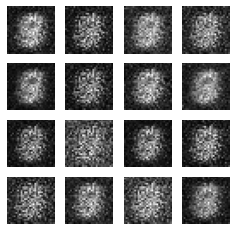

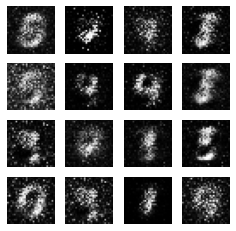

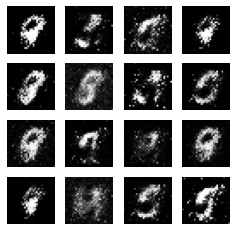

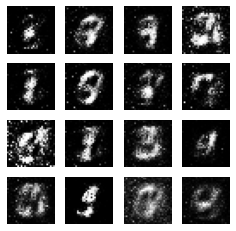

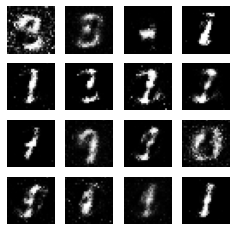

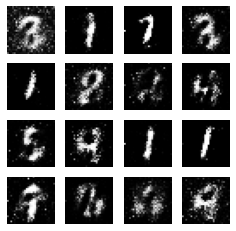

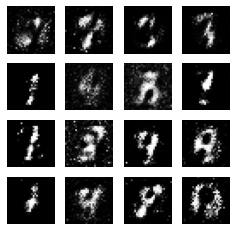

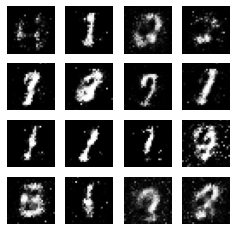

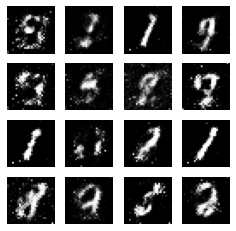

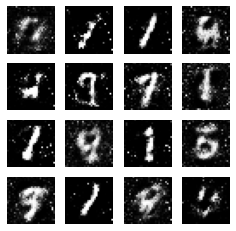

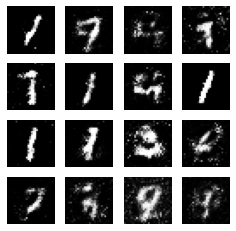

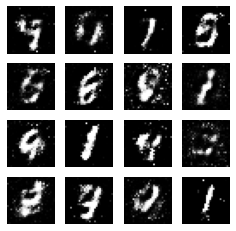

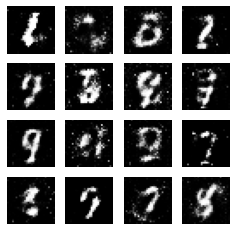

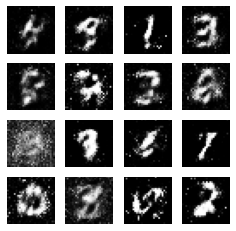

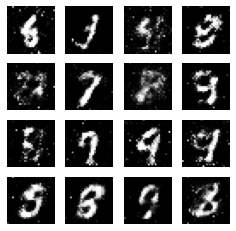

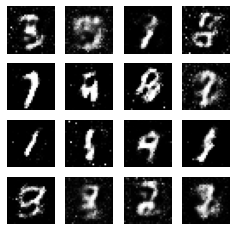

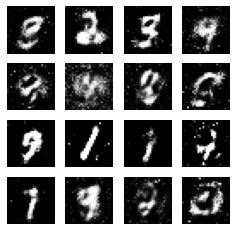

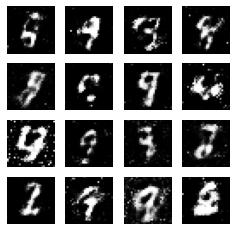

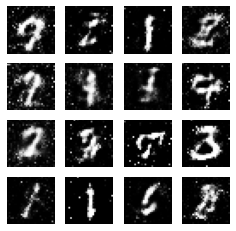

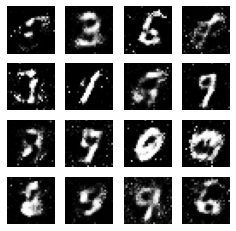

In [ ]:
# 모델 실행

iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

In [ ]:
(X2_train, _), (_, _) = mnist.load_data()
  
# axis에 따른 차원 확장
X2_train = X2_train / 127.5 - 1.0
print(X2_train.shape)
X2_train = np.expand_dims(X2_train, axis=0)
print(X2_train.shape)
X2_train = np.expand_dims(X2_train, axis=1)
print(X2_train.shape)
X2_train = np.expand_dims(X2_train, axis=2)
print(X2_train.shape)
X2_train = np.expand_dims(X2_train, axis=3)
print(X2_train.shape)

(60000, 28, 28)
(1, 60000, 28, 28)
(1, 1, 60000, 28, 28)
(1, 1, 1, 60000, 28, 28)
(1, 1, 1, 1, 60000, 28, 28)
